# 2. Обучить алгоритм продолжать последовательность
Последовательности, которые состоят из цифр (от 0 до 9) и задаются следующим образом:

x - последовательность цифр

y1 = x1

yi = xi + x1

Если yi >= 10 то yi = yi - 10

Загрузим необходимые нам библиотеки

In [34]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Напишем пару функций для генераци данных

In [35]:
def get_seq(seq_length):
    x = np.random.randint(0, 10, seq_length)  
    x1 = x[0]
    y = [(xi + x1) % 10 for xi in x]        
    return x, y

def get_dataset(num_sequences, seq_length):
    X, Y = [], []
    for _ in range(num_sequences):
        x, y = get_seq(seq_length)
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

Сгенерируем данные

In [36]:
seq_length = 25       
num_sequences = 7000  

# Генерация данных
X, Y = get_dataset(num_sequences, seq_length)

# Разделение данных на тренировочную и тестовую выборку
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Подготовим данные

In [37]:
class SequenceDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x = torch.tensor(x_data / 9.0, dtype=torch.float32) 
        self.y = torch.tensor(y_data, dtype=torch.long)       

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# DataLoader
batch_size = 64
train_dataset = SequenceDataset(X_train, Y_train)
test_dataset = SequenceDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Создадим модель. Сделаем ее с возможность выбора RNN

In [38]:
class RNNModel(nn.Module):
    def __init__(self, rnn_type, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size

        if rnn_type == "RNN":
            self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        elif rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        else:
            raise ValueError("ValueError")
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_out, _ = self.rnn(x) 
        out = self.fc(rnn_out) 
        return out

Напишем функцию для обучения и теста модели

In [39]:
# Функция обучения и тестирования модели
def train_and_evaluate(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    # Функция потерь и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        # === ТРЕНИРОВКА ===
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.unsqueeze(-1).to(device) 
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch) 
            
            loss = criterion(outputs.view(-1, 10), y_batch.view(-1))  
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

            _, predicted = torch.max(outputs, -1)  
            train_correct += (predicted == y_batch).sum().item()
            train_total += y_batch.numel() 

        train_accuracy = train_correct / train_total * 100
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss / len(train_loader))

        # TEST
        model.eval()
        test_loss = 0
        test_correct = 0 
        test_total = 0

        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.unsqueeze(-1).to(device)
                y_batch = y_batch.to(device)

                outputs = model(x_batch)
                
                # Потери
                loss = criterion(outputs.view(-1, 10), y_batch.view(-1))
                test_loss += loss.item()

                # Точность
                _, predicted = torch.max(outputs, -1)
                test_correct += (predicted == y_batch).sum().item()
                test_total += y_batch.numel()

        test_accuracy = test_correct / test_total * 100 
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss / len(test_loader))

        # LOG
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Train Loss: {train_losses[-1]:.4f}%, Test Loss: {test_losses[-1]:.2f}%")
        print(f"Train Accuracy: {train_accuracies[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.2f}")
        print()

    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, '-.', label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label="Train")
    plt.plot(test_accuracies, '-.', label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

    return 

Настроим параметры модели

In [40]:
input_size = 1
hidden_size = 128
output_size = 10
num_layers = 2
num_epochs = 30
learning_rate = 0.001

RNN

Epoch [1/30]
Train Loss: 2.2895%, Test Loss: 2.28%
Train Accuracy: 10.4400, Test Accuracy: 10.98

Epoch [2/30]
Train Loss: 2.2782%, Test Loss: 2.28%
Train Accuracy: 10.7193, Test Accuracy: 11.37

Epoch [3/30]
Train Loss: 2.2772%, Test Loss: 2.28%
Train Accuracy: 10.4279, Test Accuracy: 10.96

Epoch [4/30]
Train Loss: 2.2773%, Test Loss: 2.28%
Train Accuracy: 10.7221, Test Accuracy: 10.69

Epoch [5/30]
Train Loss: 2.2767%, Test Loss: 2.28%
Train Accuracy: 10.7293, Test Accuracy: 10.68

Epoch [6/30]
Train Loss: 2.2767%, Test Loss: 2.28%
Train Accuracy: 10.8029, Test Accuracy: 11.15

Epoch [7/30]
Train Loss: 2.2762%, Test Loss: 2.28%
Train Accuracy: 10.6664, Test Accuracy: 11.06

Epoch [8/30]
Train Loss: 2.2760%, Test Loss: 2.28%
Train Accuracy: 10.9079, Test Accuracy: 11.12

Epoch [9/30]
Train Loss: 2.2758%, Test Loss: 2.28%
Train Accuracy: 10.8621, Test Accuracy: 10.87

Epoch [10/30]
Train Loss: 2.2763%, Test Loss: 2.28%
Train Accuracy: 10.7936, Test Accuracy: 11.35

Epoch [11/30]
Train

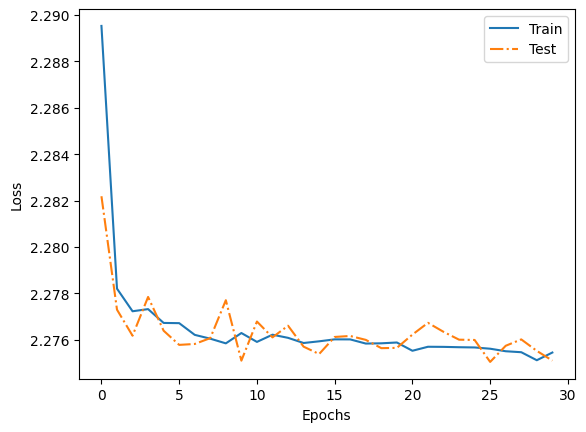

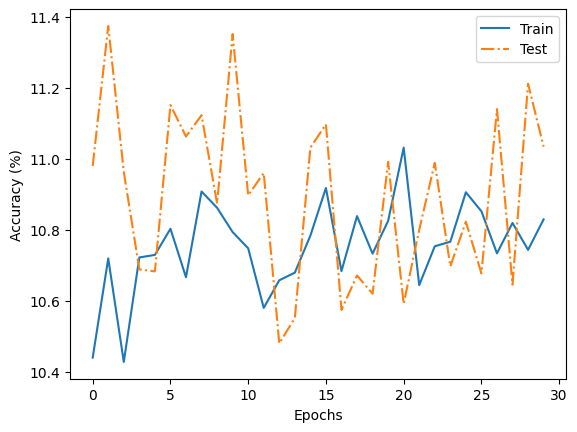

In [41]:
rnn_model = RNNModel("RNN", input_size, hidden_size, output_size, num_layers)
train_and_evaluate(rnn_model, train_loader, test_loader, num_epochs, learning_rate)

LSTM

Epoch [1/30]
Train Loss: 2.3015%, Test Loss: 2.30%
Train Accuracy: 10.2686, Test Accuracy: 10.53

Epoch [2/30]
Train Loss: 2.2891%, Test Loss: 2.28%
Train Accuracy: 10.4164, Test Accuracy: 10.52

Epoch [3/30]
Train Loss: 2.2759%, Test Loss: 2.28%
Train Accuracy: 10.4957, Test Accuracy: 10.71

Epoch [4/30]
Train Loss: 2.2746%, Test Loss: 2.27%
Train Accuracy: 10.6564, Test Accuracy: 11.05

Epoch [5/30]
Train Loss: 2.2727%, Test Loss: 2.27%
Train Accuracy: 10.7186, Test Accuracy: 10.34

Epoch [6/30]
Train Loss: 2.2705%, Test Loss: 2.27%
Train Accuracy: 10.4136, Test Accuracy: 10.39

Epoch [7/30]
Train Loss: 2.2698%, Test Loss: 2.27%
Train Accuracy: 10.4671, Test Accuracy: 10.49

Epoch [8/30]
Train Loss: 2.2680%, Test Loss: 2.27%
Train Accuracy: 10.5479, Test Accuracy: 10.93

Epoch [9/30]
Train Loss: 2.2468%, Test Loss: 2.15%
Train Accuracy: 12.3879, Test Accuracy: 18.20

Epoch [10/30]
Train Loss: 1.8362%, Test Loss: 1.49%
Train Accuracy: 34.5293, Test Accuracy: 47.80

Epoch [11/30]
Train

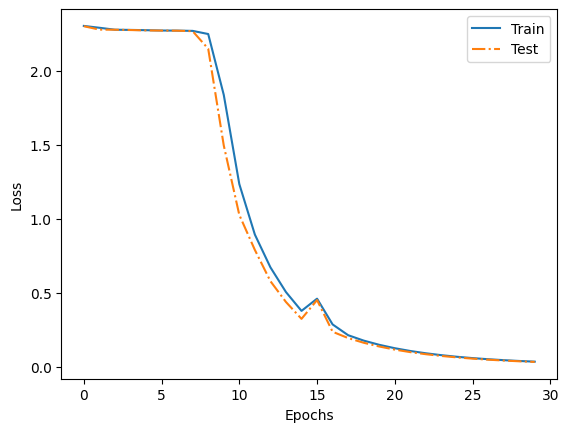

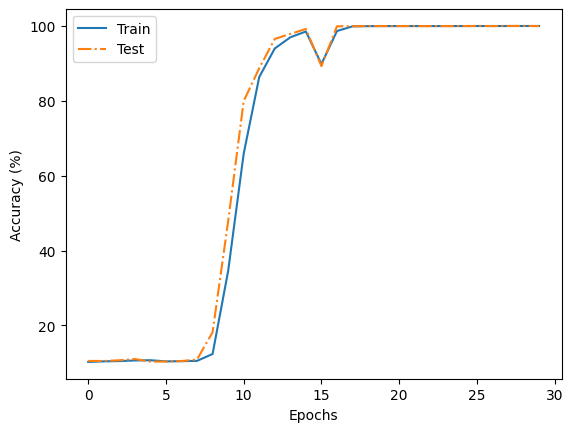

In [42]:
lstm_model = RNNModel("LSTM", input_size, hidden_size, output_size, num_layers)
train_and_evaluate(lstm_model, train_loader, test_loader, num_epochs, learning_rate)

GRU

Epoch [1/30]
Train Loss: 2.3008%, Test Loss: 2.30%
Train Accuracy: 10.3457, Test Accuracy: 10.87

Epoch [2/30]
Train Loss: 2.2855%, Test Loss: 2.28%
Train Accuracy: 10.5579, Test Accuracy: 11.10

Epoch [3/30]
Train Loss: 2.2768%, Test Loss: 2.28%
Train Accuracy: 10.5600, Test Accuracy: 10.75

Epoch [4/30]
Train Loss: 2.2758%, Test Loss: 2.27%
Train Accuracy: 10.7214, Test Accuracy: 10.64

Epoch [5/30]
Train Loss: 2.2745%, Test Loss: 2.27%
Train Accuracy: 10.5507, Test Accuracy: 10.27

Epoch [6/30]
Train Loss: 2.2735%, Test Loss: 2.27%
Train Accuracy: 10.3164, Test Accuracy: 10.03

Epoch [7/30]
Train Loss: 2.2719%, Test Loss: 2.27%
Train Accuracy: 10.2921, Test Accuracy: 10.53

Epoch [8/30]
Train Loss: 2.2617%, Test Loss: 2.19%
Train Accuracy: 11.8036, Test Accuracy: 17.11

Epoch [9/30]
Train Loss: 1.5628%, Test Loss: 1.03%
Train Accuracy: 45.5229, Test Accuracy: 68.65

Epoch [10/30]
Train Loss: 0.7248%, Test Loss: 0.51%
Train Accuracy: 86.2350, Test Accuracy: 92.15

Epoch [11/30]
Train

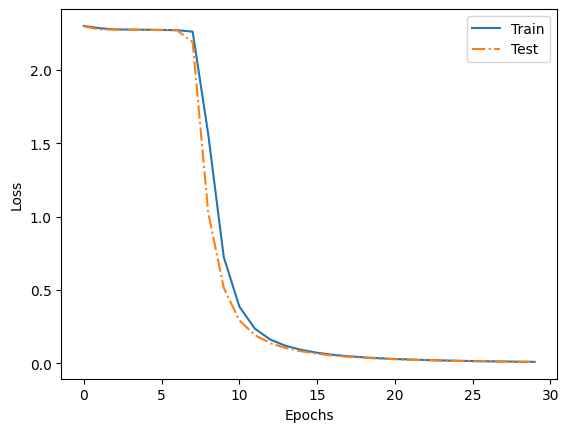

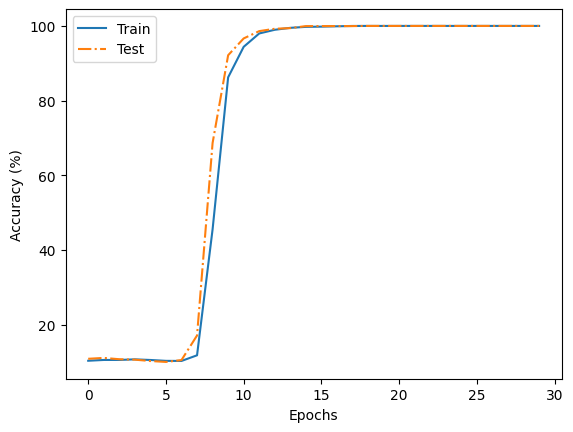

In [43]:
gru_model = RNNModel("GRU", input_size, hidden_size, output_size, num_layers)
train_and_evaluate(gru_model, train_loader, test_loader, num_epochs, learning_rate)

Напишем функцию для построения графиков и посмотрим графики лоса и акураси

## Выводы:
1. Модель RNN роказала себя не должным образом. Train и Test Loss с первых эпох начали резко падать, но после 5 эпох все затухло и Loss остался в районе двух. Accuracy прыгал в районе 10-11%. Это нам говорит о том, что модель плохо обучается и не может извлечь полезную информацию из данных.

2. Модель LSTM сначала показывала себя не очень, но с 9-11 эпохи, Loss стал стремительно уменьшаться, а точность - возрастать. Это говорит о том, что LSTM обучаеться и извлекает полезную информацию. Судя по графикам, можно было бы остановиться на 15-18 эпохах, так как там был маленкий провал, но по итогу метрики выровнялись и всё стало хорого :)
   
3. Модель GRU  показала себя лучше всего. Быстрее всех обучается и показывает отличные метрики.